In [1]:
import os
import numpy as np
import pandas as pd
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt

os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

from pathlib import Path 
from datetime import datetime,timedelta
from matplotlib.dates import DateFormatter
from cartopy.feature import NaturalEarthFeature
from searvey.coops import coops_product_within_region, coops_stations_within_region
from pyschism.mesh import Hgrid
from stormevents import StormEvent
from shapely.geometry import MultiPolygon
from shapely.ops import polygonize

In [2]:
def get_storm_track_date(storm_track, advisory):
    for idx in storm_track.linestrings[advisory]:
        track_date = idx
    return track_date

In [3]:
def format_datetime_for_coops(storm_datetime):
    return datetime(storm_datetime.year, storm_datetime.month, storm_datetime.day, storm_datetime.hour, storm_datetime.minute)

In [4]:
def plot_isobar_domains(storm_track, track_date, gdf_countries):
    figure, axis = plt.subplots(1, 1)
    figure.set_size_inches(12, 12 / 1.618)
    
    # track_date = get_storm_track_date(storm_track, 'BEST')

    axis.plot(*storm_track.wind_swaths(wind_speed=34)['BEST'][track_date].exterior.xy, 
              c='limegreen', label='34 kt')
    axis.plot(*storm_track.wind_swaths(wind_speed=50)['BEST'][track_date].exterior.xy, 
              c='blue', label='50 kt')
    axis.plot(*storm_track.wind_swaths(wind_speed=64)['BEST'][track_date].exterior.xy, 
              c='red', label='64 kt')
    axis.plot(*storm_track.linestrings['BEST'][track_date].xy, 
              c='black',label='BEST track')
    
    xlim = axis.get_xlim()
    ylim = axis.get_ylim()
    
    gdf_countries.plot(color='lightgrey', ax=axis, zorder=-1)
    
    axis.set_xlim(xlim)
    axis.set_ylim(ylim)
    axis.legend()
    axis.set_title(f'{storm_track.name}_{storm_track.year} BEST track windswatch')
    figure.savefig(f'{storm_track.name}_{storm_track.year}_BEST_track_windswatch.png')

In [5]:
def plot_coops_stations(storm_name, storm_year, coops_product, gdf_countries):
    x_vals = coops_product['x'].values
    y_vals = coops_product['y'].values
    nos_ids = coops_product['nos_id'].values
    
    figure, axis = plt.subplots(1, 1)
    figure.set_size_inches(12, 12 / 1.618)

    for idx in range(len(nos_ids)):
        axis.scatter(x_vals[idx],y_vals[idx], label=nos_ids[idx])
    
    xlim = axis.get_xlim()
    ylim = axis.get_ylim()
    
    gdf_countries.plot(color='lightgrey', ax=axis, zorder=-1)
    
    axis.set_xlim(xlim)
    axis.set_ylim(ylim)
    axis.legend()
    axis.set_title(f'COOPS stations within 50kt isotach of {storm_name}_{storm_year}')
    figure.savefig(f'{storm_name}_{storm_year}_COOPS_stations.png')

In [6]:
def coops_dataset_to_dataframe(coops_dataset):
    df_coops, ij = [], 0
    for idx in coops_dataset.coords['nos_id'].values:
        df_temp = pd.DataFrame({'date': coops_dataset.coords['t'].values,
                                idx: coops_dataset.v.values[ij,:],
                               }).set_index('date')
        df_coops.append(df_temp)
        ij = ij+1
    df_coops = pd.concat(df_coops, axis=1)       
    return df_coops

In [7]:
def adjust_coops(df_coops):
    df_coops_adjusted = pd.DataFrame()
    for coops_idx in df_coops.columns:
        df_coops_adjusted[coops_idx] = df_coops[coops_idx] - df_coops[coops_idx].values.mean()
    return df_coops_adjusted

In [8]:
def get_stations_coordinates(coops_dataset):
    coord_x = coops_dataset.x.values
    coord_y = coops_dataset.y.values
    coord_combined = np.column_stack([coord_x, coord_y])
    return coord_combined

In [9]:
def find_stations_indices(coordinates, hgrid):
    longitude = hgrid.x.T
    latitude = hgrid.y.T
    long_lat = np.column_stack((longitude.ravel(),latitude.ravel()))
    tree = sp.spatial.cKDTree(long_lat)
    dist,idx = tree.query(coordinates,k=1)
    ind = np.column_stack(np.unravel_index(idx,longitude.shape))
    return [i for i in ind]

In [10]:
def get_schism_elevation_df(ds_schism, station_indices, station_ids):
    time_array = ds_schism.time.values
    var_name = 'elevation'
    
    df, ij = [], 0
    for idx in station_ids:
        df_temp = pd.DataFrame({'date': time_array,
                                idx: ds_schism[var_name][:,int(station_indices[ij])].values,
                               }).set_index('date')
        df.append(df_temp)
        ij = ij+1 
    df = pd.concat(df, axis=1)
    return df

In [11]:
def get_common_dates(df_1, df_2):
    return df_1.index.intersection(df_2.index)

In [12]:
def plot_timeseries(df_coops, df_schism_1, df_schism_2, mid_date, domain_stations, schism_labels, storm_name, storm_year):
    
    # plot date range:
    from_date = mid_date + timedelta(days=-2)
    to_date = mid_date + timedelta(days=+2)
    
    # No. of plots and spacings:
    n_plots = len(df_coops.columns)

    fig_wspace, fig_hspace = 0.2, 0.2
    
    if n_plots <= 4:
        row, col = n_plots, 1
    else:
        row, col = int(np.ceil(n_plots/2)), 2

    fig_width = 8*(col) + fig_wspace *(col-1)
    fig_height = 2*(row) + fig_hspace *(row-1)
    
    fig, axis = plt.subplots(row , col, figsize=(fig_width, fig_height), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = fig_hspace, wspace=fig_wspace)
    axis = axis.ravel()
    idx_plt = 0
    
    for idx in df_coops.columns: 
        axis[idx_plt].plot(df_coops[idx].loc[from_date:end_date], linestyle='solid',linewidth=1.0, label='COOPS')
        axis[idx_plt].plot(df_schism_1[idx].loc[from_date:end_date], linestyle='dashed', linewidth=1.0, label=schism_labels[0])
        if df_schism_2 is not None:
            axis[idx_plt].plot(df_schism_2[idx].loc[from_date:end_date], linestyle='dotted', linewidth=1.2, label=schism_labels[1])

        axis[idx_plt].grid(axis = 'both', color = 'gray', linestyle = '-', linewidth = 0.75, alpha=0.15)
        axis[idx_plt].tick_params(axis="both",direction="in")  #, pad=0
        plt.setp(axis[idx_plt].xaxis.get_majorticklabels(), rotation=90)
                
        # format x-labels
        plt.gcf().autofmt_xdate()
        date_form = DateFormatter("%b-%d") #DateFormatter("%b-%d, %H:%M")
        axis[idx_plt].xaxis.set_major_formatter(date_form)        
        axis[idx_plt].set_ylim([-2.5,2.5])
    
        station_label = f'{idx} ({domain_stations[domain_stations.nos_id==int(idx)].name.values[0]})'
        axis[idx_plt].text(0.5, 0.975, station_label,
                           horizontalalignment='center', verticalalignment='top',
                           transform=axis[idx_plt].transAxes, size=9,weight='bold')        
        idx_plt +=1

    # add legend:
    axis[-1].legend(loc="lower right", ncol=5)
    
    fig.add_subplot(111, frame_on=False)
    plt.tick_params(labelcolor="none", bottom=False, left=False)
    plt.ylabel('WSE [m]', size=11,weight='bold')
    plt.title(f'{storm_name}_{storm_year} Water Level \n From {df_coops.index[0]} To {df_coops.index[-1]}', size=15)
    
    plt.savefig(f'{storm_name}_{storm_year}_timeseries.png')#, dpi=250)

In [13]:
def plot_scatter(df_coops, df_schism_1, df_schism_2, mid_date, domain_stations, schism_labels, storm_name, storm_year):
    
    # plot date range:
    from_date = mid_date + timedelta(days=-2)
    to_date = mid_date + timedelta(days=+2)
    
    # No. of plots and spacings:
    n_plots = len(df_coops.columns)
    row, col = int(np.ceil(n_plots/3)), 3
    fig_wspace, fig_hspace = 0.2, 0.2
    fig_width = 5*(col) + fig_wspace *(col-1)
    fig_height = 5*(row) + fig_hspace *(row-1)
    
    fig, axis = plt.subplots(row , col, figsize=(fig_width, fig_height), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = fig_hspace, wspace=fig_wspace)
    
    axis = axis.ravel()
    idx_plt = 0
    
    for idx in df_coops.columns: 
        axis[idx_plt].scatter(df_coops[idx], df_schism_1[idx], s=4, label=schism_labels[0])
        if df_schism_2 is not None:
            axis[idx_plt].scatter(df_coops[idx], df_schism_2[idx], s=4, marker='*', label=schism_labels[1])

        axis[idx_plt].axline((-0.50,-0.50), (0.50,0.50), linestyle='--', color='grey')       
        # axis[idx_plt].legend(loc="upper left")
        axis[idx_plt].tick_params(axis="both",direction="in")  #, pad=0
        plt.setp(axis[idx_plt].xaxis.get_majorticklabels(), rotation=0)
        
        station_label = f'{idx} ({domain_stations[domain_stations.nos_id==int(idx)].name.values[0]})'
        axis[idx_plt].text(0.5, 0.975, station_label,
                   horizontalalignment='center', verticalalignment='top',
                   transform=axis[idx_plt].transAxes, size=9,weight='bold')
        
        axis[idx_plt].set_xlim([-1.5,1.5])
        axis[idx_plt].set_ylim([-1.5,1.5])
        
        axis[idx_plt].legend(loc="lower right")
        axis[idx_plt].set_ylabel('SCHISM simulation [m]')
        axis[idx_plt].set_xlabel('COOPS observation [m]')
                   
        idx_plt +=1
    
    fig.add_subplot(111, frame_on=False)
    plt.tick_params(labelcolor="none", bottom=False, left=False)
    plt.title(f'{storm_name}_{storm_year} COOPS Water Level Validation \n From {df_coops.index[0]} To {df_coops.index[-1]}', size=15)
    plt.savefig(f'{storm_name}_{storm_year}_COOPS_scatters_with_stats.png')#, dpi=250)

In [14]:
def get_corr(obs,sim):
    return obs.corr(sim)

def get_mae(obs,sim):
    mae = ((np.abs(obs-sim)).sum()) / len(obs)
    # mae = (np.abs(obs-sim)).mean()
    return mae

def get_r2(obs,sim):
    nom = ((obs-obs.mean()) * (sim-sim.mean())).sum()
    den_1 = np.sqrt(((obs-obs.mean())**2).sum())
    den_2 = np.sqrt(((sim-sim.mean())**2).sum())
    return (nom/(den_1*den_2))**2

def get_rmse(obs,sim):
    # rmse = np.sqrt(((obs-sim)**2).mean())
    dif = (obs-sim)**2
    rmse = np.sqrt(dif.sum()/len(obs))
    return rmse

def get_bias(obs,sim):
    return (sim-obs).mean()

def get_rel_bias(obs,sim):
    rel_bias = get_bias(obs,sim) / obs.mean()
    return rel_bias

def calc_stats(obs,sim,mid_date):
    from_date = mid_date + timedelta(days=-2)
    to_date = mid_date + timedelta(days=+2)
    
    obs = obs.loc[from_date:to_date]
    sim = sim.loc[from_date:to_date]
    
    df_stats = pd.DataFrame(columns=['NOS_ID', 'STD_OBS', 'STD_SIM', 'CORR', 'MAE', 'R2', 'RMSE', 'BIAS', 'R_BIAS'])
    
    for idx in obs.columns:
        std_obs = '%.2f' % round(obs[idx].std(ddof=1),2)
        std_sim = '%.2f' % round(sim[idx].std(ddof=1),2)
        corr = '%.2f' % round(get_corr(obs[idx],sim[idx]),2)
        mae = '%.2f' % round(get_mae(obs[idx],sim[idx]),2)
        r2 = '%.2f' % round(get_r2(obs[idx],sim[idx]),2)
        rmse = '%.2f' % round(get_rmse(obs[idx],sim[idx]),2)
        bias = '%.2f' % round(get_bias(obs[idx],sim[idx]),2)
        rel_bias = '%.2f' % round(get_rel_bias(obs[idx],sim[idx]),2)
        
        df_temp = pd.DataFrame([[idx, std_obs, std_sim, corr, mae, r2, rmse, bias, rel_bias]],
                               columns=['NOS_ID', 'STD_OBS', 'STD_SIM', 'CORR', 'MAE', 'R2', 'RMSE', 'BIAS', 'R_BIAS'])
        df_stats = pd.concat([df_stats,df_temp], axis=0, ignore_index=True)
    return df_stats

In [15]:
gdf_countries = gpd.GeoSeries(NaturalEarthFeature(category='physical', scale='10m', name='land').geometries(), crs=4326)

In [16]:
storm_name = 'FLORENCE'
storm_year = 2018

In [ ]:
hgrid_path = Path('.../hgrid.gr3')

In [ ]:
output_path_1 = Path('.../out2d_1.nc')
# Optional second simulation: (comment/uncomment the last line)
output_path_2 = None # OR
output_path_2 = Path('.../out2d_1.nc')

In [40]:
schism_labels = ['Holland', 'GAHM'] # Name of simulation(s) for plot label

**Obtain storm track from StormEvent**

In [ ]:
# Load storm and obtain isobars from stormevent
storm = StormEvent(storm_name, storm_year)
storm_best_track = storm.track()

In [18]:
# get start and end date of storm from BEST track
track_date = get_storm_track_date(storm_best_track, 'BEST')
storm_start_date = storm_best_track.start_date
storm_end_date = storm_best_track.end_date  

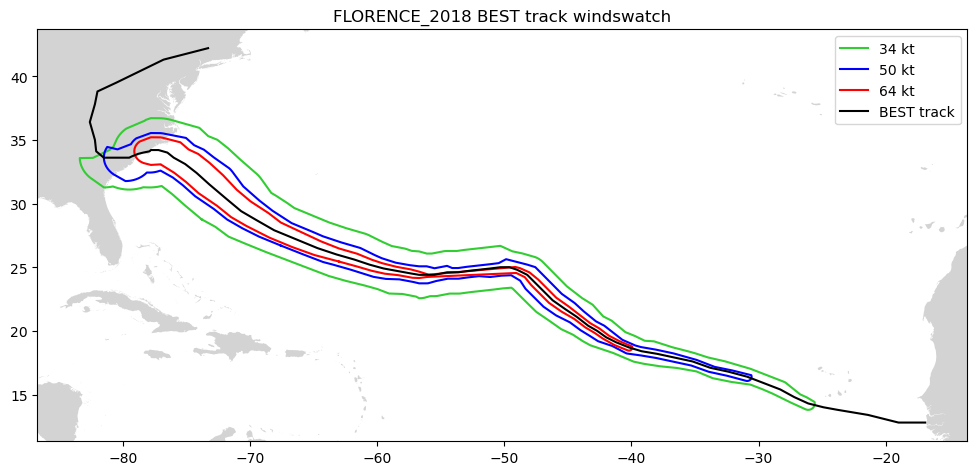

In [19]:
# plot isobars
plot_isobar_domains(storm_best_track, track_date, gdf_countries)

**COOPS data retrieval**

In [20]:
# Define COOPS domain 
isotach_limit = 50
isotach_region = MultiPolygon(list(polygonize(storm_best_track.wind_swaths(wind_speed=isotach_limit)['BEST'][track_date].exterior)))

In [21]:
# Define product, datum, and date range:
variable = "water_level" # Can be "predictions" (for tidal), "water_level", ... 
datum = "NAVD" # Can be "NAVD", "MSL", "STND", ...
start_date = format_datetime_for_coops(storm_start_date)
end_date = format_datetime_for_coops(storm_end_date)

In [22]:
coops_product = coops_product_within_region(variable, 
                                            datum=datum, 
                                            region=isotach_region, 
                                            start_date=start_date, 
                                            end_date=end_date)

coops_product = coops_product.drop_vars(['f','s','q'])  # Remove unwanted/NaN variables

In [23]:
station_ids = coops_product['nos_id'].values

In [24]:
domain_stations = coops_stations_within_region(region=isotach_region)
domain_stations = domain_stations.reset_index()
domain_stations = domain_stations[domain_stations['nos_id'].isin(coops_product.nos_id.values.astype('int'))] # stations that have data records during the storm
# # domain_stations = domain_stations[domain_stations.status=='active'] # Only keep active stations 

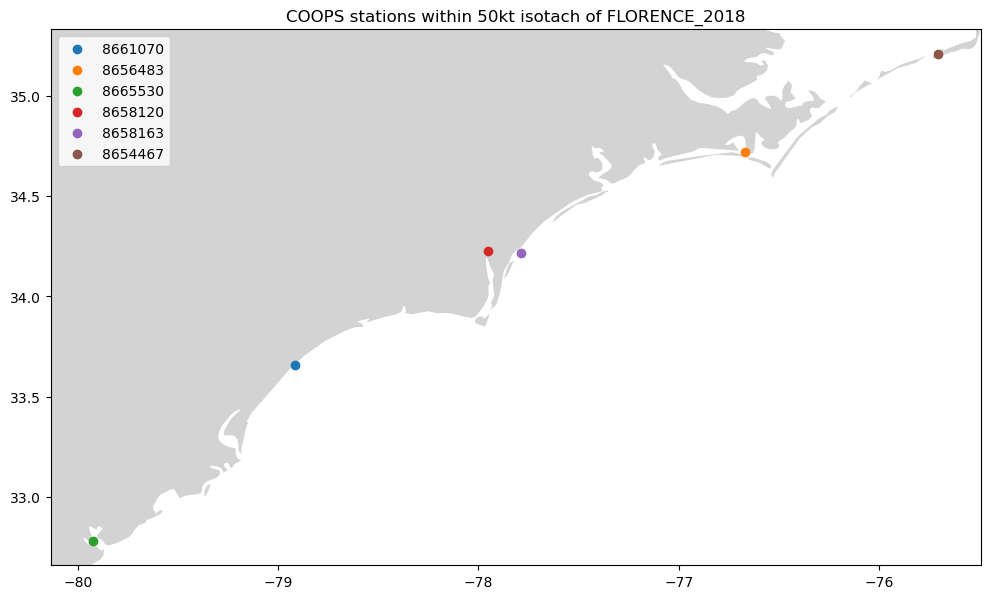

In [25]:
plot_coops_stations(storm_name,storm_year,coops_product,gdf_countries)

In [26]:
# convert COOPS nc to df
df_coops = coops_dataset_to_dataframe(coops_product)

In [27]:
# Adjust water level (if needed)
df_coops = adjust_coops(df_coops)

**Read hgrid and find indices  corresponding to COOPS stations**

In [29]:
hgrid = Hgrid.open(hgrid_path, crs=4326)

In [ ]:
# hgrid.write(path='./hgrid.2dm', format='2dm') # to save the mesh and open it in QGIS

In [30]:
stations_coordinates = get_stations_coordinates(coops_product)     

In [31]:
stations_indices = find_stations_indices(stations_coordinates, hgrid)

**Read SCHISM output(s)**

In [33]:
ds_schism_1 = xr.open_dataset(output_path_1)

if output_path_2 is not None:
    ds_schism_2 = xr.open_dataset(output_path_2)

In [34]:
df_schism_1 = get_schism_elevation_df(ds_schism_1, stations_indices, station_ids)

if output_path_2 is not None:
    df_schism_2 = get_schism_elevation_df(ds_schism_2, stations_indices, station_ids)

Get common dates between observed and simulation

In [35]:
common_dates = get_common_dates(df_coops, df_schism_1)

In [36]:
df_coops = df_coops.loc[common_dates]
df_schism_1 = df_schism_1.loc[common_dates]

if output_path_2 is not None:
    df_schism_2 = df_schism_2.loc[common_dates]
else:
    df_schism_2=None

User defined mid-date for stats and plotting timeseries 

In [37]:
min_date_limit = storm_start_date + timedelta(days=2, hours=12)
max_date_limit = storm_end_date - timedelta(days=2, hours=12)

In [38]:
print(f'Select a date between {min_date_limit.date()} and {max_date_limit.date()}:')

Select a date between 2018-09-01 and 2018-09-16:


In [39]:
mid_date = datetime.strptime('2018-9-14', '%Y-%m-%d') # i.e., '2018-9-14' for Florence

**Plots**

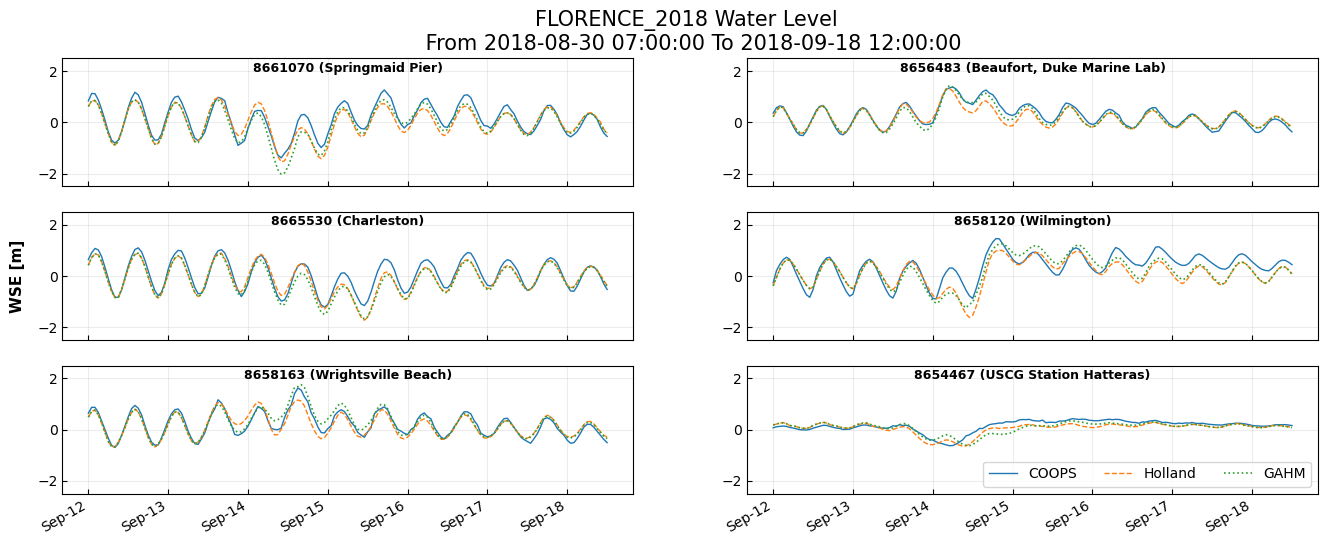

In [41]:
plot_timeseries(df_coops=df_coops, 
                df_schism_1=df_schism_1, 
                df_schism_2=df_schism_2, 
                mid_date=mid_date, 
                domain_stations=domain_stations,
                schism_labels=schism_labels,
                storm_name=storm_name,
                storm_year=storm_year)

# # OR (if df_schism_2=None)
# plot_timeseries(df_coops=df_coops, 
#                 df_schism_1=df_schism_1, 
#                 df_schism_2=None, 
#                 mid_date=mid_date, 
#                 domain_stations=domain_stations,
#                 schism_labels=schism_labels,
#                 storm_name=storm_name,
#                 storm_year=storm_year)

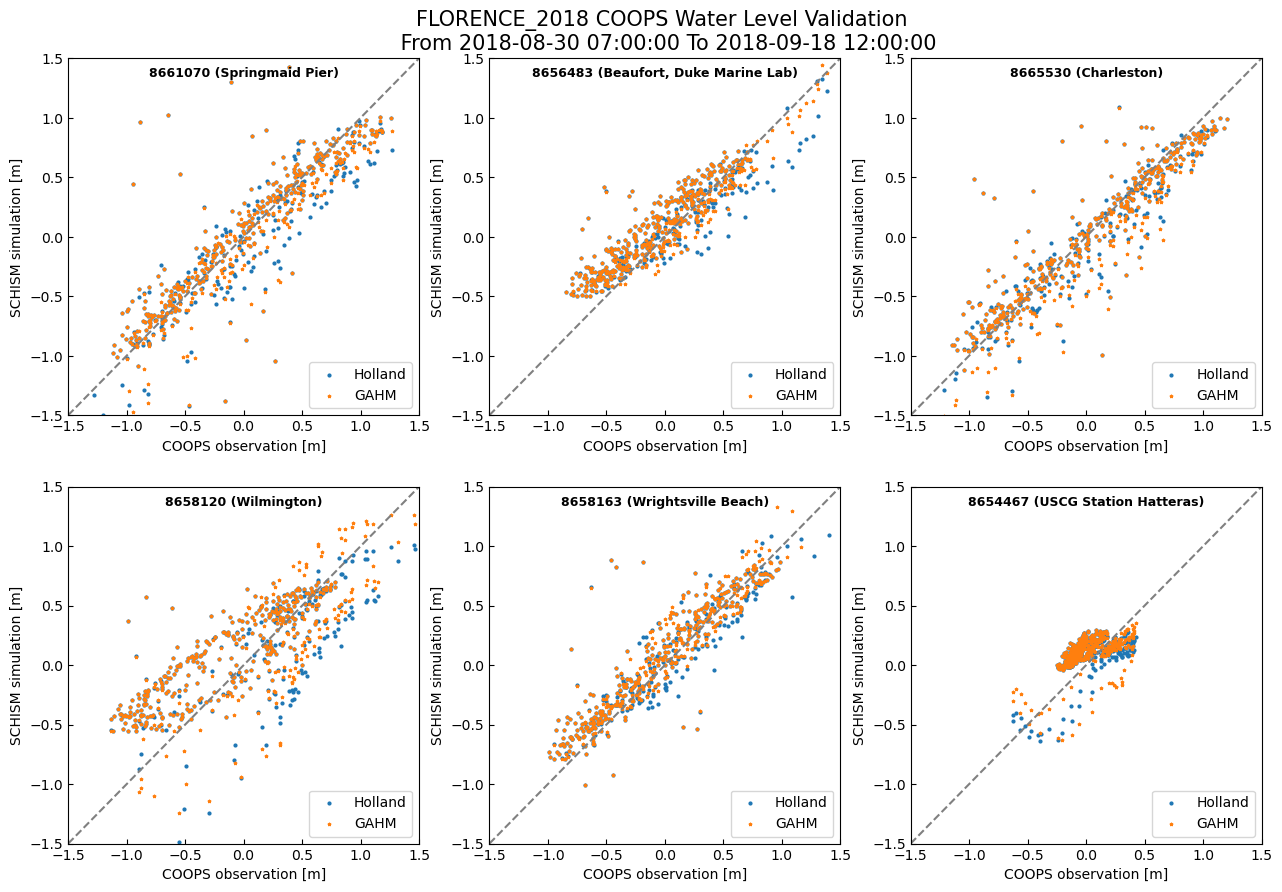

In [42]:
plot_scatter(df_coops=df_coops, 
             df_schism_1=df_schism_1,
             df_schism_2=df_schism_2, 
             mid_date=mid_date, 
             domain_stations=domain_stations,
             schism_labels=schism_labels,
             storm_name=storm_name,
             storm_year=storm_year)

# # OR (if df_schism_2=None)
# plot_scatter(df_coops=df_coops, 
#              df_schism_1=df_schism_1,
#              df_schism_2=None, 
#              mid_date=mid_date, 
#              domain_stations=domain_stations,
#              schism_labels=schism_labels,
#              storm_name=storm_name,
#              storm_year=storm_year)

**Calculate stats**

In [43]:
df_stats_1 = calc_stats(df_coops, df_schism_1, mid_date)

In [44]:
if df_schism_2 is not None:
    df_stats_2 = calc_stats(df_coops, df_schism_2, mid_date)

In [45]:
df_stats_1

,NOS_ID,STD_OBS,STD_SIM,CORR,MAE,R2,RMSE,BIAS,R_BIAS
0,8661070,0.67,0.66,0.93,0.25,0.87,0.29,-0.16,-1.89
1,8656483,0.47,0.40,0.93,0.15,0.87,0.21,-0.13,-0.33
2,8665530,0.66,0.67,0.94,0.22,0.89,0.28,-0.16,27.31
3,8658120,0.60,0.63,0.85,0.24,0.73,0.35,-0.10,-0.43
4,8658163,0.53,0.50,0.93,0.16,0.87,0.20,-0.07,-0.23
5,8654467,0.27,0.26,0.84,0.15,0.71,0.17,-0.08,-1.00


In [46]:
df_stats_2

,NOS_ID,STD_OBS,STD_SIM,CORR,MAE,R2,RMSE,BIAS,R_BIAS
0,8661070,0.67,0.72,0.96,0.24,0.92,0.30,-0.22,-2.57
1,8656483,0.47,0.46,0.98,0.11,0.96,0.13,-0.08,-0.22
2,8665530,0.66,0.68,0.96,0.26,0.92,0.32,-0.25,43.43
3,8658120,0.60,0.70,0.87,0.27,0.75,0.35,-0.02,-0.11
4,8658163,0.53,0.55,0.95,0.15,0.90,0.18,0.06,0.20
5,8654467,0.27,0.25,0.70,0.16,0.49,0.21,-0.06,-0.73
